# Proyecto 2
## Bioseñales y sistemas. 2024
### María J. Ostos, Cristian Florez, Juan A. Sañudo


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import scipy.signal as signal 
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import detrend
from scipy.signal import welch
from numpy.polynomial.polynomial import Polynomial

1. De los artículos:

https://www.nature.com/articles/s41746-023-00966-w

https://www.nature.com/articles/s41598-020-59821-7

https://www.sciencedirect.com/science/article/pii/S2405844024032316

Para cada artículo hacer un diagrama de flujo de las metodologías usadas en los artículos (10%)

Explicar en sus palabras las metodologías desarrolladas (10%)

2. Descargar los datos ECGDataDenoised.zip de:
https://figshare.com/collections/ChapmanECG/4560497/1

De la base de datos extraer los registros que correspondan a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). Esta información está en el archivo Diagnostics.xlsx

In [2]:
ruta_diagnostics="./otros/Diagnostics.xlsx"
df_diagnostics = pd.read_excel(ruta_diagnostics)

# Crear el nuevo dataframe filtrando por la columna 'Rhythm'
datos_diagnostics = df_diagnostics[(df_diagnostics['Rhythm'] == 'SB') | (df_diagnostics['Rhythm'] == 'AFIB')]

#Tamaño del nuevo dataframe
datos_diagnostics.shape

fs=500
tiempo_diagnostics = np.arange(0, datos_diagnostics.shape[0]/fs,1/fs)

datos_diagnostics.head()


,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
5,MUSE_20180112_120347_79000,SB,NONE,46,FEMALE,57,57,70,404,393,38,24,9,225,260,427
6,MUSE_20180114_075026_69000,AFIB,TWC,80,FEMALE,98,86,74,360,459,69,83,17,215,252,395


In [3]:
print(f'Tamaño del dataframe: {datos_diagnostics.shape} \nTamaño del vector tiempo: {tiempo_diagnostics.shape[0]}')

Tamaño del dataframe: (5669, 16) 
Tamaño del vector tiempo: 5669


De estos registros los análisis para el presente proyecto deben hacerse en la derivación II

In [4]:
ruta_II="./otros/MUSE_20180111_155115_19000.csv"
df_II = pd.read_csv(ruta_II,delimiter=',',names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

datos_II = df_II["II"]

tiempo_II = np.arange(0, datos_II.shape[0]/fs,1/fs)

datos_II.head()

0   -358.97
1   -336.81
2   -315.56
3   -296.23
4   -279.75
Name: II, dtype: float64

3. Programar las fórmulas 1 al 4 que se encuentran en el artículo (15%). Consultar que significado y utilidad del biespectro (Realice la gráfica) (5%)
https://arxiv.org/pdf/1809.08451

## Significado de las funciones:
- ### Deviation: 
- ### Compress
- ### Bispectrum
- ### Bicoherence

In [5]:
def Grafica(tiempo,data,datos_process,nombre="Procesado"):
    
    # Crear una figura con dos subplots en una fila
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
    # Graficar en el primer subplot
    ax1.plot(tiempo,data, color="k")
    ax1.set_title('Original')

    # Graficar en el segundo subplot
    ax2.plot(tiempo,datos_process, color="r", linestyle='--')
    ax2.set_title(nombre)

    plt.show()

In [6]:
#Ecuación 1
def detrend_n_deviation(data,tiempo):
    datos_detrend=signal.detrend(data)
    datos_deviation=np.mean((data-datos_detrend)**2)
    return datos_detrend, datos_deviation

In [7]:
# Ecuación 2
def compress(signal):
    xmin, xmax = np.min(signal), np.max(signal)
    if xmin == xmax:
        return signal  # Evitar dividir por cero si no hay rango
    compressed_signal = (signal - xmin) / (xmax - xmin)
    return np.array(compressed_signal)

In [8]:
#Ecuaciones 3 y 4
def bispectrum_bicoherence(signal, N=8192):
    # Asegurar que la longitud de la señal sea múltiplo de N (o hacer padding si es necesario)
    length = len(signal)
    if length % N != 0:
        padding = N - (length % N)
        signal = np.pad(signal, (0, padding), mode='constant')

    # Dividir la señal en segmentos de longitud N
    segments = [signal[i:i + N] for i in range(0, len(signal), N)]

    # Inicializar las sumas del bispectrum y la bicoherencia
    bispectrum_sum = 0
    bicoherence_sum = 0

    for segment in segments:
        # Calcular la FFT de cada segmento
        X = fft(segment)
        f1, f2 = np.meshgrid(X, X)

        # Calcular el bispectro
        bispectrum = X * X * np.conj(fft(segment))
        bispectrum_sum += bispectrum
        bicoherence_sum += np.abs(bispectrum)

    # Normalizar la bicoherencia
    bicoherence = np.abs(bispectrum_sum) / bicoherence_sum
    return bispectrum_sum, bicoherence


4. Para cada señal extraer la frecuencia que contiene la máxima potencia y Gráfiquela (15%)

In [9]:
# Función para calcular la frecuencia de máxima potencia
def max_power_frequency(signal, fs):
    f, Pxx = welch(signal, fs)
    max_power_freq = f[np.argmax(Pxx)]
    return max_power_freq, f, Pxx

5. Para cada señal sumar el número de frecuencias que son significativas para bicoherencia (cuales tienen un valor superior a ![image](https://github.com/user-attachments/assets/636a4170-c3f7-4789-9100-f2a0ce0033c3) ) (20%)

In [10]:
# Función para sumar las frecuencias significativas en bicoherencia
def significant_frequencies_bicoherence(bicoherence, N):
    threshold = np.sqrt(9.2 / (2 * N))
    significant_frequencies = np.sum(bicoherence > threshold)
    return significant_frequencies

6. Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 al 5 y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP) y suma de frecuencias significativas en bicoherencia (sFSB):

| Registro | Estado | fMP | sFSB  |
| --- | --- | --- | --- |
| --- | --- | --- | --- |
| --- | --- | --- | --- |


In [14]:
def signal_process(datos,tiempo,fs):
    print("Aplicando detrend")
    data_detrended=detrend_n_deviation(datos,tiempo)
    print(f'La desviación es {data_detrended[1]}')
    Grafica(tiempo,datos,data_detrended[0],nombre="Detrended")

    print("Aplicando compress")
    data_compressed=compress(data_detrended[0])
    Grafica(tiempo,data_detrended[0],data_compressed,"Compressed")
    
    print("Aplicando biespectro y bicoherencia")
    bisp_Bic=bispectrum_bicoherence(data_compressed,N=4000)
    # Grafica(datos[:len(bisp_Bic[0])],data_compressed[:len(bisp_Bic[0])],bisp_Bic[0],"bispectrum and bicoherence")
    Grafica(tiempo[:len(bisp_Bic[0])],data_compressed[:len(bisp_Bic[0])],bisp_Bic[0],"bispectrum and bicoherence")
    # Grafica(tiempo,data_compressed,bisp_Bic[0],"bispectrum and bicoherence")
    
    print("calculando la máxima potencia")
    max_p=max_power_frequency(datos,fs)
    print(f'La máxima potencia es {max_p[0]}')
    plt.figure(figsize=(10, 5))
    plt.semilogy(max_p[1], max_p[2], label='Densidad Espectral de Potencia')
    plt.axvline(max_p[0], color='r', linestyle='--', label=f'Máxima Frecuencia: {max_p[0]:.2f} Hz')
    plt.title('Densidad Espectral de Potencia')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Densidad Espectral [V^2/Hz]')
    plt.legend()
    plt.grid()
    plt.show()

    print("calculando Frecuencias significativas")
    sig_f=significant_frequencies_bicoherence(bisp_Bic[1],len(bisp_Bic[1]))
    print(f'Frecuencias significativas para bicoherencia: {sig_f} Hz')

Aplicando detrend
La desviación es 56.8344164090374


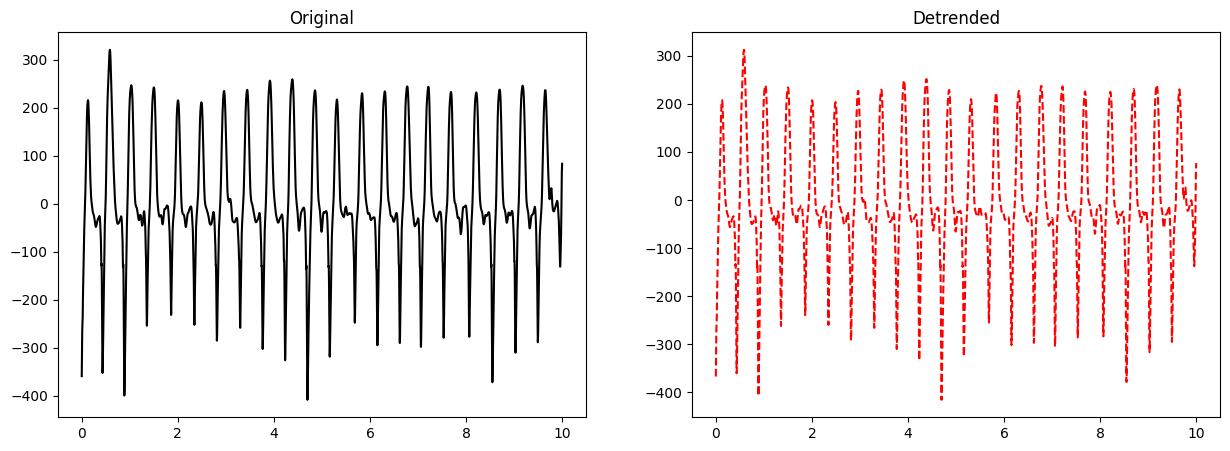

Aplicando compress


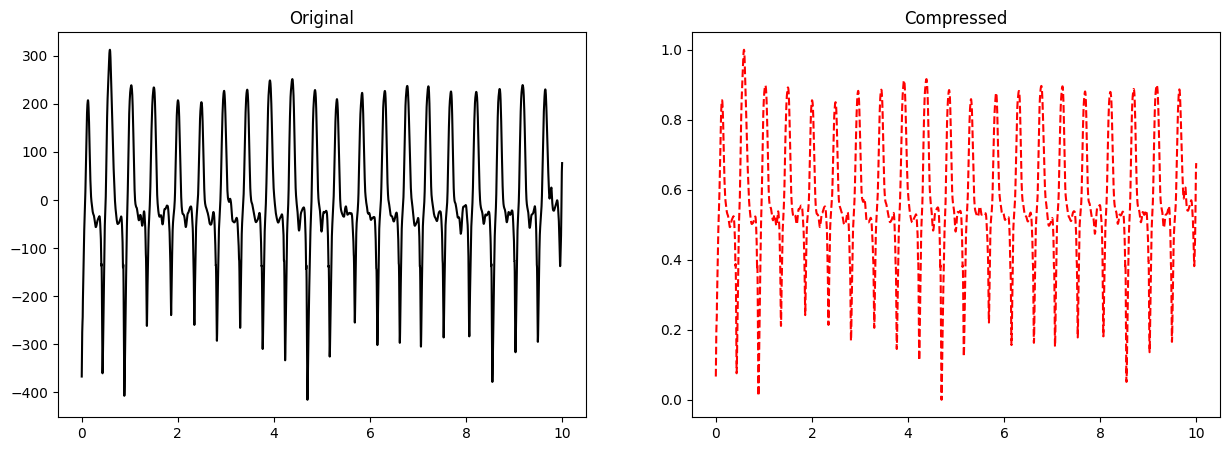

Aplicando biespectro y bicoherencia


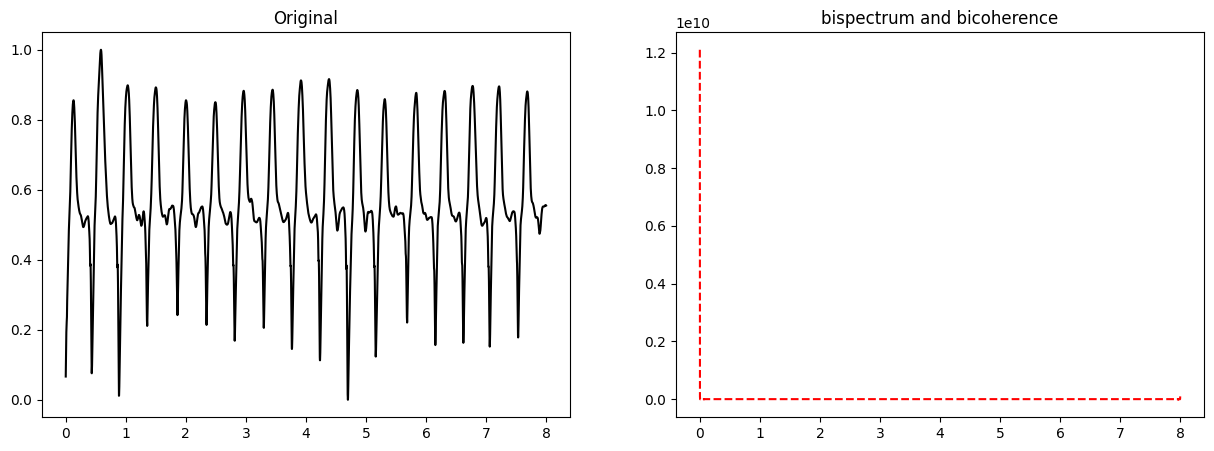

calculando la máxima potencia
La máxima potencia es 1.953125


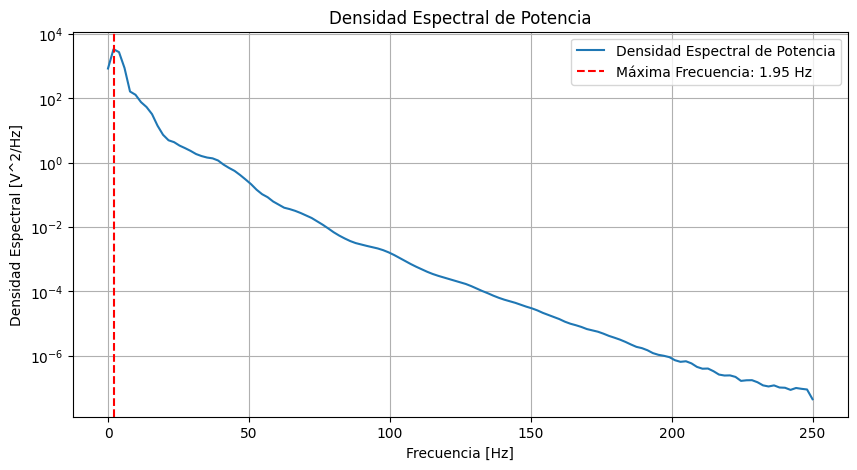

calculando Frecuencias significativas
Frecuencias significativas para bicoherencia: 3998 Hz


In [15]:
signal_process(datos_II,tiempo_II,fs)

7. Para las señales de análisis del punto 2 aplicar las rutinas del punto 3 al 5 y hacer un informe que permita evidenciar las diferencias entre las señales SB y AFIB utilizando las herramientas de estadística descriptiva (5%)

8. Indicar si hay o no diferencias estadísticas entre las características espectrales del punto 4 y 5 para las dos poblaciones de estudio (5%)


((5669,), (5669, 16))

9. Hacer un informe con todos los puntos anteriores (15%)